# Support Vector CLassifier

### 1. Tải bộ dữ liệu

### 2. Import các thư viện cần thiết

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.svm import SVC
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 3. Đọc dữ liệu
Sử dụng pandas, ta đọc dữ liệu từ file .csv lên như sau:

In [11]:
dataset_path = './breast-cancer.csv'
df = pd.read_csv(
    dataset_path,
    names=[
        'age',
        'meonpause',
        'tumor-size',
        'inv-nodes',
        'node-caps',
        'deg-malig',
        'breast',
        'breast-quad',
        'irradiat',
        'label'
    ]
)

In [12]:
df.head()

,age,meonpause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,label
0,'40-49','premeno','15-19','0-2','yes','3','right','left_up','no','recurrence-events'
1,'50-59','ge40','15-19','0-2','no','1','right','central','no','no-recurrence-events'
2,'50-59','ge40','35-39','0-2','no','2','left','left_low','no','recurrence-events'
3,'40-49','premeno','35-39','0-2','yes','3','right','left_low','yes','no-recurrence-events'
4,'40-49','premeno','30-34','3-5','yes','2','left','right_up','no','recurrence-events'


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   meonpause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    278 non-null    object
 5   deg-malig    286 non-null    object
 6   breast       286 non-null    object
 7   breast-quad  285 non-null    object
 8   irradiat     286 non-null    object
 9   label        286 non-null    object
dtypes: object(10)
memory usage: 22.5+ KB


### 4. Tiền xử lí dữ liệu

Quan sát bộ dữ liệu trên, có thể nhận ra bộ dữ liệu hiện tại có nhiều vấn đề cần chúng ta giải quyết trước khi đưa vào huấn luyện. Trong đó, dễ thấy chúng ta cần phải mã hóa các cột dữ liệu dạng categorical và giải quyết các missing values. Các bước thực hiện như sau:

(a) **Filling missing values**: Từ kết quả df.info(), ta có thể thấy các cột thuộc tính node caps và breast-quad đang không có đủ 286 non-null values, đồng nghĩa rằng hai cột này đang chứa missing values. Việc giải quyết vấn đề này sẽ có rất nhiều cách, song để đơn giản hóa vấn đề, chúng ta sẽ áp dụng chiến lược khỏa lắp các missing values bằng giá trị xuất hiện nhiều nhất trong cột tương ứng. 


In [14]:
df['node-caps'] = df['node-caps'].fillna(df['node-caps'].mode()[0])
df['breast-quad'] = df['breast-quad'].fillna(df['breast-quad'].mode()[0])

(b) **Encode categorical features**: Toàn bộ các cột thuộc tính của bộ dữ liệu đều ở dạng categorical. Vì vậy, ta cần mã hóa chúng thành dạng số trước khi đưa vào huấn luyện mô hình. Để thực hành các kiểu encode khác nhau, trong bài này chúng ta sẽ sử dụng cả hai OneHotEncoder() và OrdinalEncoder() cho một số cột thuộc tính khác nhau. 

In [15]:
y = df['label']
X = df.drop('label', axis=1)

Tiếp đến, ta xác định tên các cột sẽ sử dụng OrdinalEncoder() và các cột sẽ sử dụng
 OneHotEncoder():

In [16]:
non_rank_features = ['meonpause', 'node-caps', 'breast', 'breast-quad', 'irradiat']
rank_features = ['age', 'tumor-size', 'inv-nodes', 'deg-malig']

Chúng ta sẽ sử dụng đồng thời hai Encoder này thông qua ColumnTransformer() của
 sklearn như sau:

In [17]:
transformer = ColumnTransformer(
    transformers=[
        ("OneHot", OneHotEncoder(drop='first'), non_rank_features),
        ("Ordinal", OrdinalEncoder(), rank_features)
    ],
    remainder='passthrough'
)
X_transformed = transformer.fit_transform(X)

 Như vậy ta đã encode xong các thuộc tính. Để có thể quan sát dữ liệu sau khi encode
 một cách trực quan, ta sẽ biến đổi biến X_transformed thành DataFrame như sau:

In [19]:
onehot_features = transformer.named_transformers_['OneHot'].get_feature_names_out(non_rank_features)
all_features = onehot_features.tolist() + rank_features

X_encoded = pd.DataFrame(
    X_transformed,
    columns=all_features
)

In [21]:
X_encoded.head()

,meonpause_'lt40',meonpause_'premeno',node-caps_'yes',breast_'right',breast-quad_'left_low',breast-quad_'left_up',breast-quad_'right_low',breast-quad_'right_up',irradiat_'yes',age,tumor-size,inv-nodes,deg-malig
0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,6.0,0.0,1.0
3,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,2.0,6.0,0.0,2.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,5.0,4.0,1.0


(c) **Encode label**: Label của bộ dữ liệu gồm có hai giá trị (class) là "**recurrence-events**" và "**no-recurrence-events**". Tương tự như categorical features, ta cũng cần phải đưa label này về dạng số. Trong sklearn, ta có LabelEncoder() chuyên dùng để encode các label. Cách sử dụng như sau:

In [23]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

(d) **Normalization**: Cuối cùng, để thuận tiện trong việc training, ta cũng áp dụng kỹ thuật chuẩn hóa dữ liệu vào các thuộc tính X như sau:

In [24]:
normalizer = StandardScaler()
X_normalized = normalizer.fit_transform(X_encoded)

### 5. Chia tập dữ liệu train, val

Sau khi hoàn tất tiền xử lý,ta bắt đầu phân chia tập dữ liệu ban đầu thành hai tập con. Một tập"train" dùng cho việc huấn luyện mô hình, một tập "val" dùng để đánh giá mô hình sau khi train.Tỉ lệ chia ở đây sẽ là 7:3.

In [25]:
test_size = 0.3
random_state = 1
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(
    X_normalized, y_encoded,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

### 6. Huấn luyện mô hình

In [26]:
classifier = SVC(
    random_state=random_state
)
classifier.fit(X_train, y_train)

SVC(random_state=1)

### 7. Đánh giá mô hình


In [27]:
y_pred = classifier.predict(X_val)
scores = accuracy_score(y_pred, y_val)

print('Evaluation results on validation set:')
print(f'Accuracy: {scores}')

Evaluation results on validation set:
Accuracy: 0.686046511627907


# Support Vector Regression (SVR)

### 1. Tải bộ dữ liệu

### 2. Import các thư viện cần thiết:

In [28]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.svm import SVR 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

### 3. Đọc dữ liệu
Sử dụng pandas, ta đọc dữ liệu từ file .csv lên như sau:

In [29]:
dataset_path = './auto-insurance.csv'
df = pd.read_csv(
    dataset_path,
    names=[
        'n_claims',
        'total_payment'
    ]
)

In [30]:
df.head()

,n_claims,total_payment
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   n_claims       63 non-null     int64  
 1   total_payment  63 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.1 KB


 Vì bộ dữ liệu chỉ có một thuộc tính, ta hoàn toàn có thể trực quan bộ dữ liệu này lên đồ thị như sau:

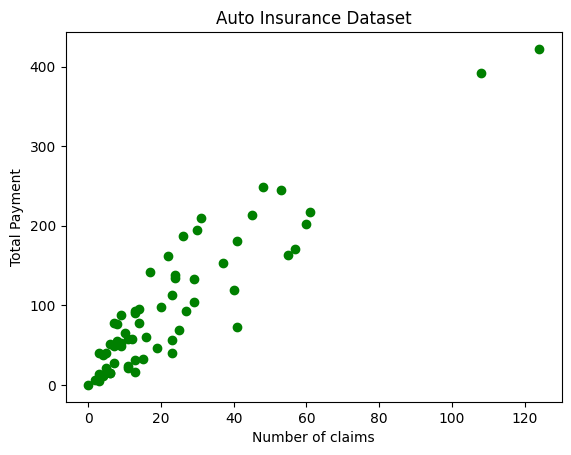

In [32]:
plt.scatter(df['n_claims'], df['total_payment'], color='green')
plt.title('Auto Insurance Dataset')
plt.xlabel('Number of claims')
plt.ylabel('Total Payment')
plt.show()

### 4. Chuẩn hóa dữ liệu (Normalization)

In [33]:
normalizer = StandardScaler()
df_normalized = normalizer.fit_transform(df)

### 5. Chia bộ dữ liệu train, val

In [34]:
X, y = df_normalized[:, 0], df_normalized[:, 1]
X = X.reshape(-1, 1)

test_size = 0.3
random_state = 1
is_shuffle = True
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

### 6. Huấn luyện mô hình

In [36]:
regressor = SVR()
regressor.fit(X_train, y_train)

SVR()

### 7. Đánh giá mô hình

In [37]:
y_pred = regressor.predict(X_val)
mae = mean_absolute_error(y_pred, y_val)
mse = mean_squared_error(y_pred, y_val)

print('Evaluation results on validation set:')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

Evaluation results on validation set:
Mean Absolute Error: 0.4549655045116023
Mean Squared Error: 0.5406791138567528


# Trắc nghiệm

### Câu 1

In [38]:
# Đáp án: B

### Câu 2

In [39]:
# Đáp án: B

### Câu 3

In [40]:
# Đáp án: C

### Câu 4

In [41]:
# Đáp án: A

### Câu 5 

In [42]:
# Đáp án: C

### Câu 6

In [43]:
# Đáp án: D

### Câu 7

In [44]:
# Đáp án: A

### Câu 8

In [45]:
# Đáp án: B

### Câu 9

In [46]:
# Đáp án: D

### Câu 10

In [47]:
# Đáp án: C

### Câu 11

In [48]:
# Đáp án: A

### Câu 12

In [ ]:
# Đáp án: B

### Câu 13

In [ ]:
# Đáp án: A

### Câu 14

In [ ]:
# Đáp án: B

### Câu 15

In [49]:
# Đáp án: B

### Câu 16

In [50]:
# Đáp án: D

### Câu 17

In [51]:
# Đáp án: B

### Câu 18

In [52]:
# Đáp án: A

### Câu 19

In [53]:
# Đáp án: C

### Câu 20

In [54]:
# Đáp án: A

### Câu 21

In [55]:
# Đáp án: C

### Câu 22

In [ ]:
# Đáp án: B